In [1]:
%%capture
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from tensorflow.keras import regularizers
import os
import time
import numpy as np
import gc
from tensorflow.keras.models import model_from_json
!pip install tqdm
!pip install h5py
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from sklearn import preprocessing

In [2]:
def scale(x):

    return (x - np.mean(x)) / np.std(x)

In [3]:
def preprocess(x):
    
    return x[:,:,:int(0.75*x.shape[2])]

In [4]:
os.chdir("/home/pk2573/Capstone_Data/Re15sh20_DNScoarse8")
u = preprocess(scale(loadmat('u_F_xyz_T1.mat')["u_F"]))
v = preprocess(scale(loadmat('v_F_xyz_T1.mat')["v_F"]))
w = preprocess(scale(loadmat('w_F_xyz_T1.mat')["w_F"]))
tau_12 = preprocess(scale(loadmat('tau12_xyz_T1.mat')["tau12"]))
tau_13 = preprocess(scale(loadmat('tau13_xyz_T1.mat')["tau13"]))
tau_23 = preprocess(scale(loadmat('tau23_xyz_T1.mat')["tau23"]))

#### Switches

In [5]:
all_taus = False

### 1. Generate Input Dataset

In [6]:
x = np.array([u, v, w])
x = np.transpose(x, [1, 2, 3, 0])
x = np.pad(x, ((3,3), (3,3), (3,3), (0,0)), 'constant', constant_values = 0)

In [7]:
sample = []
size = 3
y_tau_12 = []
y_tau_13 = []
y_tau_23 = []
for i in tqdm_notebook(range(size, x.shape[0] - size)):
    for j in range(size, x.shape[1] - size):
        for k in range(size, x.shape[2] - size):
            sample.append(x[i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, :])
            y_tau_12.append(tau_12[i - size][j - size][k - size])
            y_tau_13.append(tau_13[i - size][j - size][k - size])
            y_tau_23.append(tau_23[i - size][j - size][k - size])

In [8]:
x = np.stack(sample, axis = 0)
print(x.shape)

y_tau_12 = np.array(y_tau_12)
y_tau_13 = np.array(y_tau_13)
y_tau_23 = np.array(y_tau_23)

del sample
del u 
del v
del w
del tau_12
del tau_13
del tau_23
gc.collect()

(784896, 7, 7, 7, 3)


7

### 2. Create Model

In [9]:
class DNN(object):
    
    def __init__(self, activation, initializer, regularizer, x_train, y_train, epochs, batch_size, input_shape, val_split):
        self.activation = activation
        self.initializer = initializer
        self.regularizer = regularizer
        self.x_train = x_train
        self.y_train = y_train
        self.epochs = epochs
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.val_split = val_split
        
        pass 
    
    def create_model(self):
        model = keras.Sequential([
            tf.keras.layers.Flatten(input_shape = self.input_shape),
            tf.keras.layers.Dense(128, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dense(1)
        ])
        
        return model
    
    def callbacks(self):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               min_delta = 0.001,
                                               patience = 0,
                                               verbose = 0)
        
        return early_stopping
    
    def run_model(self):
        model = self.create_model()
        model.compile(optimizer = tf.train.AdamOptimizer(), 
              loss = "mse")
        
        history = model.fit(self.x_train, self.y_train, 
                    epochs = self.epochs, 
                    validation_split = self.val_split, 
                    batch_size =  self.batch_size,
                    verbose = 0)
        
        return history, model

### 3. Run Model

Predicting tau_12
R^2: 0.6738
Correlation: 0.8470
Saved model to disk

Predicting tau_13
R^2: 0.7325
Correlation: 0.8910
Saved model to disk

Predicting tau_23
R^2: 0.7111
Correlation: 0.8734
Saved model to disk



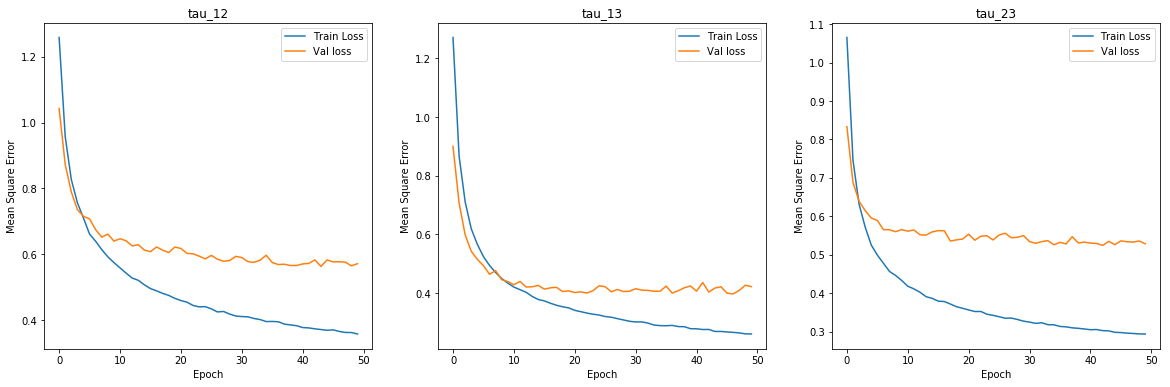

In [11]:
if all_taus:
    taus = [(y_tau_11, "tau_11"), (y_tau_12, "tau_12"), (y_tau_13, "tau_13"), (y_tau_22, "tau_22"), (y_tau_23, "tau_23"), (y_tau_33, "tau_33")]
else:
    taus = [(y_tau_12, "tau_12"), (y_tau_13, "tau_13"), (y_tau_23, "tau_23")]
    
activation = tf.nn.relu
initializer = None
regularizer = None
epochs = 50
batch_size = 5000
input_shape = (x.shape[1], x.shape[2], x.shape[3], x.shape[4])
val_split = 0.2

fig = plt.figure(figsize = (20, 6))

i = 1
for (y, name) in taus:
    print("Predicting " + name)
    mask =  np.random.rand(x.shape[0]) < 0.80
    x_train, x_test = x[mask,:,:,:,:], x[~mask,:,:,:,:]
    y_train, y_test = y[mask], y[~mask]
    
    model = DNN(activation, initializer, regularizer, x_train, y_train, epochs, batch_size, input_shape, val_split)
    history, model = model.run_model()
    
    del x_train
    del y_train
    gc.collect()
    
    fig.add_subplot(1, len(taus), i)
    plt.plot(history.epoch, np.array(history.history['loss']), label = 'Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']), label = 'Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.title(name)
    plt.legend()
    
    y_pred = model.predict(x_test).flatten()
    y_true = y_test
    print("R^2: %.4f" % r2_score(y_true, y_pred))
    print("Correlation: %.4f" % np.corrcoef(y_pred, y_true)[0, 1])
    
    model_name_json = "model_" + name + ".json"
    model_name_h5 = "model_" + name + ".h5"
    model_json = model.to_json()
    with open(model_name_json, "w") as json_file:
        json_file.write(model_json)
    model.save_weights(model_name_h5)
    print("Saved model to disk\n")
    
    del x_test
    del y_true
    del y_pred
    del y_test
    del model
    del y
    gc.collect()
    i += 1

plt.show()
